https://github.com/langchain-ai/langchain-academy/blob/main/module-2/state-reducers.ipynb

https://github.com/langchain-ai/langchain-academy/blob/main/module-2/multiple-schemas.ipynb

In [1]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

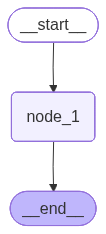

In [ ]:

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [4]:
graph.invoke({"foo":3})

---Node 1---


{'foo': 4}

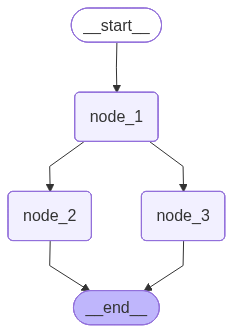

In [5]:
class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"foo" : 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")

---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


* we need to use reducer here, as both Node2 and Node3 are at the same level and they are running in parallel, hence both the nodes trying to update the state at the same time, which is not valid

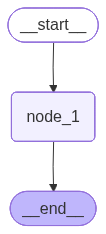

In [ ]:
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int], add] # <- `add` is a builtin reducer function and it will add the values in the list. Annotated is from typing_extensions

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [10]:
graph.invoke({"foo": [1]})

---Node 1---


{'foo': [1, 2]}

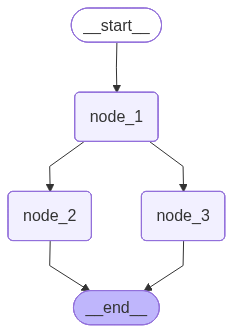

In [12]:
class State(TypedDict):
    foo: Annotated[list[int], add] # <- `add` is a builtin reducer function and it will add the values in the list. Annotated is from typing_extensions

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
graph.invoke({"foo": [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

* Custom Reducer

In [14]:
def reducer_update(left, right):
    if not left:
        left = []
    if not right:
        right = []
    return left + right

In [27]:
class State(TypedDict):
    foo: Annotated[list[int], reducer_update] # <- `add` is a builtin reducer function and it will add the values in the list. Annotated is from typing_extensions

def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [3]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [2]}

builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()
graph.invoke({"foo": [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 2]}

In [29]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# Define a custom TypedDict that includes a list of messages with add_messages reducer
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    # etc

# Use MessagesState, which includes the messages key with add_messages reducer
class ExtendedMessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    added_key_1: str
    added_key_2: str
    # etc

In [32]:
MessagesState.__annotations__

{'messages': ForwardRef('Annotated[list[AnyMessage], add_messages]', module='langgraph.graph.message')}

In [43]:
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: InputState):
    print(state,"************")
    return {"answer": state["question"]+". How are you?", "notes": "... his is name is Lance"}

def answer_node(state: OverallState) -> OutputState:
    print(state,">>>>>>>")
    return {"answer":state["answer"]+". bye, see you later!"}

graph = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
# display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"question":"My name is Lance.","notes":"good notes"})

{'question': 'My name is Lance.'} ************
{'question': 'My name is Lance.', 'answer': 'My name is Lance.. How are you?', 'notes': '... his is name is Lance'} >>>>>>>


{'answer': 'My name is Lance.. How are you?. bye, see you later!'}